In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# train data info
categorical_feature_number = 13945
df_numeric_columns = ['I1', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'I10', 'I11', 'I12', 'I13']
df_categorical_columns = ['C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C10', 'C11', 
                        'C13', 'C14', 'C15', 'C17', 'C18','C19', 'C20',
                       'C22', 'C23', 'C24', 'C25', 'C26', 'I2']

In [3]:
# define fm first part
# linear部分也使用 embedding 的形式
class LinearLayer(layers.Layer):
    
    def __init__(self, activation="sigmoid"):
        super(LinearLayer, self).__init__()
        self.activation=activation
        self.dense_layer = layers.Dense(1, activation=self.activation)
        
    def call(self, inputs):
        return self.dense_layer(inputs)


In [4]:
# define numeric embedding
class NumericEmbeddingLayer(layers.Layer):
    
    def __init__(self, input_dim, output_dim, name=""):
        super(NumericEmbeddingLayer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.embedding_w = self.add_weight(shape=(self.input_dim, self.output_dim)
                                          , initializer="random_normal"
                                          , trainable=True
                                          , name=name)
        
    def call(self, inputs):
        assert(inputs.shape[1]==self.input_dim)
        inputs = layers.RepeatVector(self.output_dim)(inputs)
        inputs = tf.transpose(inputs, perm=[0,2,1])
        return inputs * self.embedding_w


In [5]:
 # define catrgorical embedding
class CategoricalEmbeddingLayer(layers.Layer):
    
    def __init__(self, input_dim, output_dim, name=""):
        super(CategoricalEmbeddingLayer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.embedding_layers = layers.Embedding(self.input_dim, self.output_dim, name=name)
        
    def call(self, inputs):
        return self.embedding_layers(inputs)


In [6]:
embedding_dim = 8
numeric_column_number = len(df_numeric_columns)
categorical_column_number = len(df_categorical_columns)
feature_dict_dim = categorical_feature_number

In [7]:
# define model
# fm model: linear
# fm_linear_dim = 10000000
# fm_linear_layer = LinearLayer()
# fm_linear_input = tf.keras.Input(shape=(fm_linear_dim), name="fm_linear_input")
# fm_linear_output = fm_linear_layer(fm_linear_input)
# print(fm_linear_output)

numeric_input = keras.Input(shape=(numeric_column_number,), name="numeric_input")
categorical_input = keras.Input(shape=(categorical_column_number,), name="categorical_input")



""" linear 部分尝试使用embedding来实现"""
fm_linear_numeric_feature_embedding_layer = NumericEmbeddingLayer(numeric_column_number, 1)
fm_linear_numeric_feature_embedding_input = fm_linear_numeric_feature_embedding_layer(numeric_input)

fm_linear_categorical_feature_embedding_layer = CategoricalEmbeddingLayer(feature_dict_dim, 1)
fm_linear_categorical_feature_embedding_input = fm_linear_categorical_feature_embedding_layer(categorical_input)

print(fm_linear_numeric_feature_embedding_input)
print(fm_linear_categorical_feature_embedding_input)

fm_linear_output = layers.concatenate([fm_linear_numeric_feature_embedding_input, fm_linear_categorical_feature_embedding_input]
                                     , axis=1
                                     , name="linear_input_concat")
fm_linear_output = tf.squeeze(fm_linear_output, axis=2, name="linear_squeeze")
fm_linear_output = layers.Dense(1, activation=tf.nn.relu, name="fm_linear_ouput")(fm_linear_output)
print(fm_linear_output)
""" linear embedding end """


""" cross """
# fm model : cross
# numeric
numeric_feature_embedding_layer = NumericEmbeddingLayer(numeric_column_number, embedding_dim)
numeric_feature_embedding_input = numeric_feature_embedding_layer(numeric_input)
# categorical
categorical_feature_embedding_layer = CategoricalEmbeddingLayer(feature_dict_dim, embedding_dim)
categorical_feature_embedding_input = categorical_feature_embedding_layer(categorical_input)
# fm crossoutput
fm_embedding_input = layers.concatenate([numeric_feature_embedding_input, categorical_feature_embedding_input]
                                        , axis=1
                                        , name="embedding_concat")
print(fm_embedding_input)
sum_then_square = tf.square(tf.reduce_sum(fm_embedding_input, axis=1))
square_then_sum = tf.reduce_sum(tf.square(fm_embedding_input) ,axis=1)
fm_cross_output = tf.subtract(sum_then_square, square_then_sum)
print(fm_cross_output)
""" cross end """


# fm model
# fm output
fm_out = layers.concatenate([fm_linear_output, fm_cross_output], axis=1, name="fm_out")
print(fm_out)

Tensor("numeric_embedding_layer/Identity:0", shape=(None, 12, 1), dtype=float32)
Tensor("categorical_embedding_layer/Identity:0", shape=(None, 22, 1), dtype=float32)
Tensor("fm_linear_ouput/Identity:0", shape=(None, 1), dtype=float32)
Tensor("embedding_concat/Identity:0", shape=(None, 34, 8), dtype=float32)
Tensor("Sub:0", shape=(None, 8), dtype=float32)
Tensor("fm_out/Identity:0", shape=(None, 9), dtype=float32)


In [8]:
# deep model
deep_struct = {"L1":128,"L2":64,"L3":8}
deep_input = layers.Reshape((1, (numeric_column_number+categorical_column_number)*embedding_dim), name="deep_reshape_layer")(fm_embedding_input)
print(deep_input)
x1 = layers.Dense(deep_struct["L1"], activation=tf.nn.relu, name="deep_x1")(deep_input)
x2 = layers.Dense(deep_struct["L2"], activation=tf.nn.relu, name="deep_x2")(x1)
deep_out = layers.Dense(deep_struct["L3"], activation=tf.nn.relu, name="deep_out")(x2)
print(deep_out)


Tensor("deep_reshape_layer/Identity:0", shape=(None, 1, 272), dtype=float32)
Tensor("deep_out/Identity:0", shape=(None, 1, 8), dtype=float32)


In [9]:
# deepfm model
deep_out_squeeze = tf.squeeze(deep_out, axis=1, name="deep_squeeze")
deepfm_output = layers.concatenate([fm_out, deep_out_squeeze], axis=1)
deepfm_output = layers.Dense(1, activation='sigmoid', name="deepfm_out")(deepfm_output)
print(deepfm_output)

Tensor("deepfm_out/Identity:0", shape=(None, 1), dtype=float32)


In [10]:
# Define Model
model = keras.Model(inputs=[numeric_input, categorical_input], outputs=[deepfm_output])
model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy','AUC'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
numeric_input (InputLayer)      [(None, 12)]         0                                            
__________________________________________________________________________________________________
categorical_input (InputLayer)  [(None, 22)]         0                                            
__________________________________________________________________________________________________
numeric_embedding_layer_1 (Nume (None, 12, 8)        96          numeric_input[0][0]              
__________________________________________________________________________________________________
categorical_embedding_layer_1 ( (None, 22, 8)        111560      categorical_input[0][0]          
______________________________________________________________________________________________

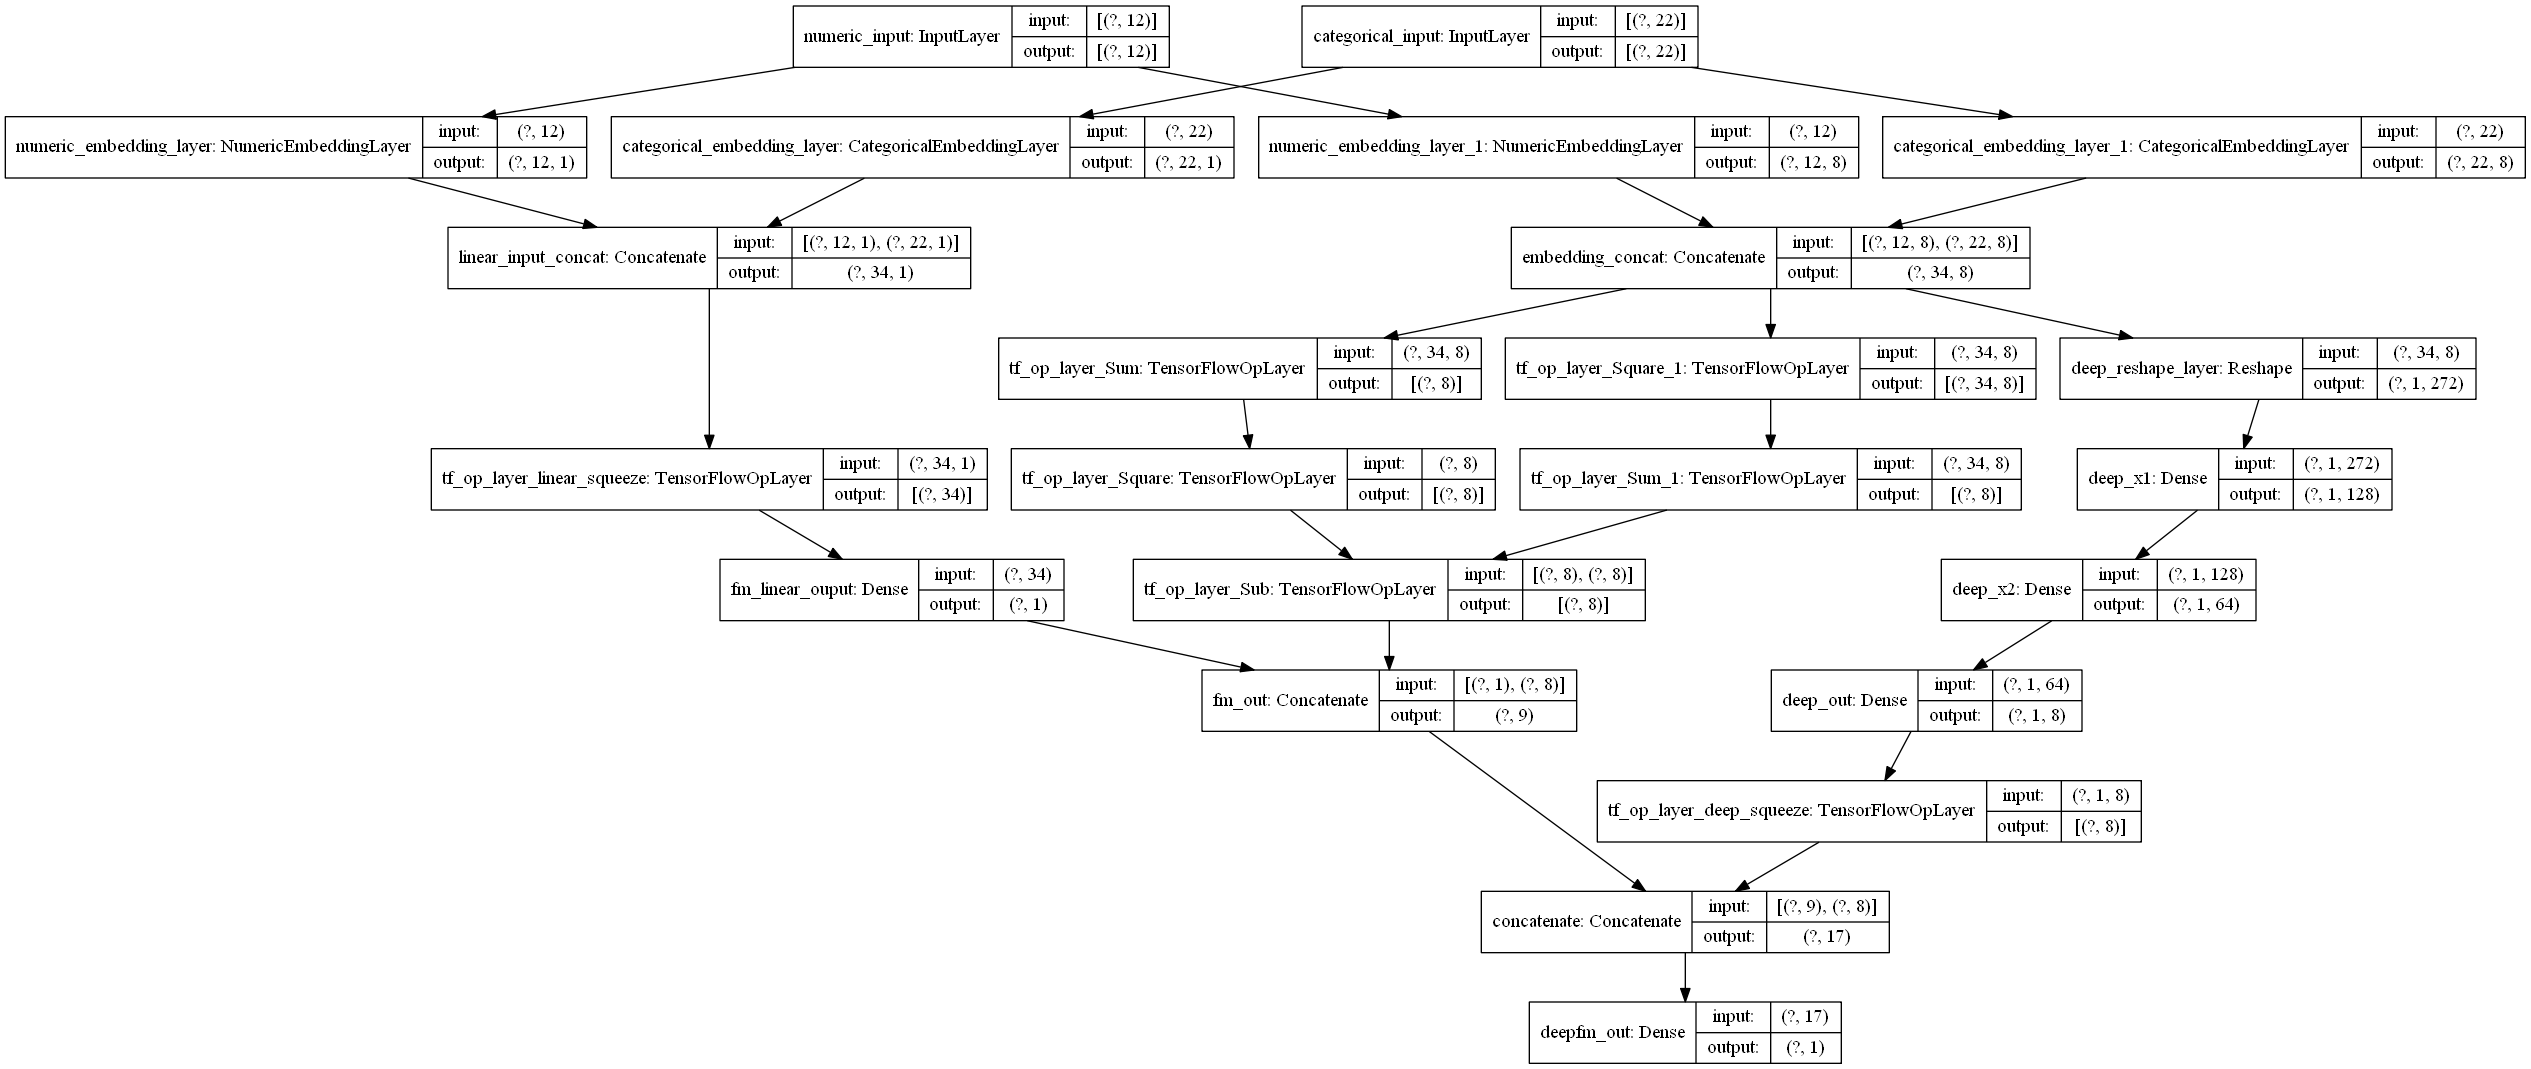

In [11]:
from matplotlib import pyplot as plt
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

In [12]:
# read data
features = pd.read_csv("features.csv")
labels = pd.read_csv("labels.csv")#.reset_index(drop=True)

number = features.shape[0]
split=0.9

train_features = features[0: int(split*number)]
train_labels = labels[0: int(split*number)]


""" test dataset """
test_features =  features[int(split*number):]
test_labels =  labels[int(split*number):]
x_test_numeric = test_features[df_numeric_columns].to_numpy()
x_test_categorical = test_features[df_categorical_columns].to_numpy()
y_test = test_labels.to_numpy()
validation_data = ({"numeric_input":x_test_numeric, "categorical_input":x_test_categorical}, y_test)
""" test data end """



batch_size = 1024
def data_generator(features, labels, batch_size=batch_size):
    sample_number = features.shape[0] - 1
    idx = 0
    while 1:
        if idx > sample_number or idx + batch_size > sample_number:
            idx = 0
        x_numeric = features[idx:idx+batch_size][df_numeric_columns].to_numpy()
        x_categorical = features[idx:idx+batch_size][df_categorical_columns].to_numpy()
        y = labels[idx:idx+batch_size].to_numpy()
        
        idx += batch_size
        
        yield ({"numeric_input":x_numeric, "categorical_input":x_categorical}, y)
        


history = model.fit(data_generator(train_features, train_labels)
          , batch_size=batch_size
          , steps_per_epoch=600000/batch_size
          , epochs=10
          , verbose=1
          , validation_data=validation_data)
    

Epoch 1/10
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
586/585 [==============================] - 6s 10ms/step - loss: 0.4907 - accuracy: 0.7707 - auc: 0.7479 - val_loss: 0.4717 - val_accuracy: 0.7793 - val_auc: 0.7729
Epoch 2/10
586/585 [==============================] - 6s 10ms/step - loss: 0.4622 - accuracy: 0.7837 - auc: 0.7865 - val_loss: 0.4705 - val_accuracy: 0.7807 - val_auc: 0.7754
Epoch 3/10
586/585 [==============================] - 6s 10ms/step - loss: 0.4534 - accuracy: 0.7884 - auc: 0.7963 - val_loss: 0.4713 - val_accuracy: 0.7809 - val_auc: 0.7756
Epoch 4/10
586/585 [==============================] - 6s 10ms/step - loss: 0.4461 - accuracy: 0.7922 - auc: 0.8043 - val_loss: 0.4745 - val_accuracy: 0.7813 - val_auc: 0.7737
Epoch 5/10
586/585 [==============================] - 6s 11ms/step - loss: 0.4393 - accuracy: 0.7963 - auc: 0.8115 - val_loss: 0.4798 - val_accuracy: 0.7755 - val_auc: 0.7677
Epoch 6/10
586/585 [========================

{'loss': [0.4906785488128662, 0.46224445104599, 0.45340320467948914, 0.4460560083389282, 0.4393497407436371, 0.431082546710968, 0.4224429428577423, 0.4140104651451111, 0.4059041142463684, 0.3979734480381012], 'accuracy': [0.770686149597168, 0.7837097644805908, 0.7883692383766174, 0.7922388315200806, 0.7962700724601746, 0.8010395765304565, 0.8058473467826843, 0.8110301494598389, 0.8157280087471008, 0.820539116859436], 'auc': [0.7478975057601929, 0.7864885330200195, 0.7963018417358398, 0.8043438792228699, 0.8115158677101135, 0.8197134137153625, 0.8281140327453613, 0.8357853293418884, 0.8427881598472595, 0.8495157361030579], 'val_loss': [0.47170594334602356, 0.47049590945243835, 0.471285879611969, 0.474461168050766, 0.4798039495944977, 0.49090632796287537, 0.4960380494594574, 0.5016442537307739, 0.5151689052581787, 0.5227886438369751], 'val_accuracy': [0.779283344745636, 0.7807000279426575, 0.7809333205223083, 0.7812833189964294, 0.7755333185195923, 0.7720500230789185, 0.7723166942596436,

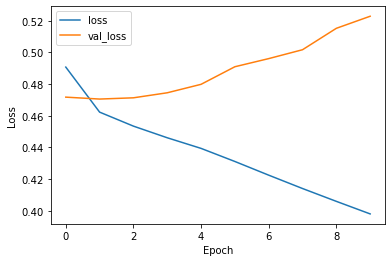

In [15]:
# plot auc
# print(history.history)
# plt.plot(history.history['auc'], label='auc')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


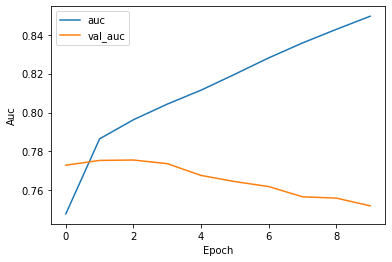

In [16]:
plt.plot(history.history['auc'], label='auc')
plt.plot(history.history['val_auc'], label='val_auc')
plt.xlabel('Epoch')
plt.ylabel('Auc')
plt.legend()